In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

C:\Users\Admin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pickle

In [3]:

num_rows_to_read = 100000
df_train = pd.read_csv('goodreads_train.csv', nrows=num_rows_to_read)

print('train set: {0}'.format(df_train.shape))
df_train.head()


FileNotFoundError: [Errno 2] No such file or directory: 'goodreads_train.csv'

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       100000 non-null  object
 1   book_id       100000 non-null  int64 
 2   review_id     100000 non-null  object
 3   rating        100000 non-null  int64 
 4   review_text   100000 non-null  object
 5   date_added    100000 non-null  object
 6   date_updated  100000 non-null  object
 7   read_at       90552 non-null   object
 8   started_at    67308 non-null   object
 9   n_votes       100000 non-null  int64 
 10  n_comments    100000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 8.4+ MB


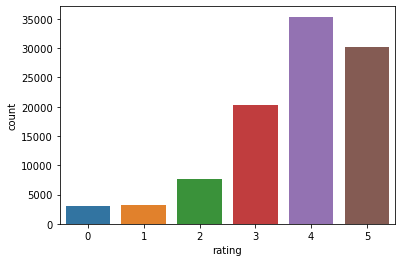

In [42]:
sns.countplot(x=df_train['rating']);

In [43]:
# Modify the form of some words
replace_list = {r"'m": ' am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [44]:
# Apply the clean_text function
df_train['review_text'] = df_train['review_text'].apply(lambda p: clean_text(p))
y = df_train['rating']

In [45]:
import spacy

nlp = spacy.load('en_core_web_sm')
# We will delete 'not' from stopwords because in sometimes it affects on meaning
nlp.vocab['not'].is_stop = False



In [46]:
stop_words = set(stopwords.words('english'))
punctuation = list(punctuation)

lemmatizer = WordNetLemmatizer()

In [47]:
def remove_stop_words(document):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(document))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Remove single digit 
    document = re.sub(r'\s*\d\s+', '', document)

    # Tokenizer, Stemmer and removing stop_words
    document = word_tokenize(document)
        
    document = [lemmatizer.lemmatize(word, pos='v') for word in document if word not in stop_words and word not in punctuation]

    document = ' '.join(document)
        
    return document

In [48]:
# Apply the remove_stop_words function
df_train['review_text'] = df_train['review_text'].apply(lambda x: remove_stop_words(x))

In [49]:
df_train['review_text'][256]

'star two word knox master really enjoy book jen frederick one favorite new adult writers sexy engage sack fast pace refreshingly funny story jen frederick write like breath fresh air story refresh verrra sexy also sweet funny time love knox master college football superstar ellie transfer student might perfect match smart athletic understand game football wait hide secret could jeopardize futures well knox virgin often find new adult book hold enough romance sexy time sack plus steamy well write story provide know glimpse world american college football plus absolutely love witty back forth knox ellie fact knox virgin well usually doubt thomas storyline work ellie finally get together slow burn build totally worth scenes two chart hot sack sexy light fast pace read fan sport romance plenty humor little bite drama add terrific read knox master could possibly hotter really look forward book support character love sack highly recommend arc provide return honest review'

We using a technique below called over-sampling or under-sampling to address the class imbalance in the data

In [50]:
from sklearn.utils import resample
#majority = max(df_train['rating'].value_counts())
majority = 10000
df_0 = df_train[(df_train['rating']==0)] 
df_1 = df_train[(df_train['rating']==1)] 
df_2 = df_train[(df_train['rating']==2)] 
df_3 = df_train[(df_train['rating']==3)]
df_4 = df_train[(df_train['rating']==4)]
df_5 = df_train[(df_train['rating']==5)] 

df_0_upsampled = resample(df_0, replace=True, n_samples= majority, random_state=44) 
df_1_upsampled = resample(df_1, replace=True, n_samples= majority, random_state=44) 
df_2_upsampled = resample(df_2, replace=True, n_samples= majority, random_state=44) 
df_3_upsampled = resample(df_3, replace=True, n_samples= majority, random_state=44)
df_4_upsampled = resample(df_4, replace=True, n_samples= majority, random_state=44)
df_5_upsampled = resample(df_5, replace=True, n_samples= majority, random_state=44) 

df_upsampled = pd.concat([df_0_upsampled, df_1_upsampled, df_2_upsampled, df_4_upsampled, df_3_upsampled, df_5_upsampled])

In [51]:
# delete the not important variables
del [df_0_upsampled, df_1_upsampled, df_2_upsampled, df_4_upsampled, df_3_upsampled, df_5_upsampled]

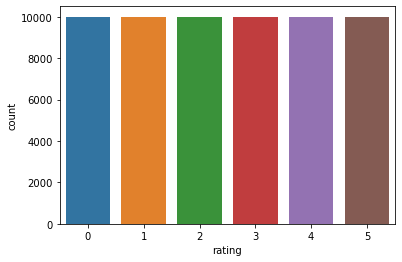

In [52]:
# Display the count of each type of rating after balancing
sns.countplot(x=df_upsampled['rating']);

In [53]:
tfidfconverter = TfidfVectorizer()
X_ = tfidfconverter.fit_transform(df_upsampled['review_text'])

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_, df_upsampled['rating'], test_size=0.01, random_state=1000)

In [55]:
X_test.shape, y_test.shape

((600, 66329), (600,))

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dt_model = DecisionTreeClassifier()

# Train the model
dt_model.fit(X_train, y_train)

# Make Predictions
y_pred = dt_model.predict(X_test)

In [57]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.71


In [58]:
# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       103
           1       0.84      0.98      0.90        90
           2       0.78      0.79      0.78       123
           3       0.57      0.54      0.56       101
           4       0.46      0.41      0.43        91
           5       0.60      0.54      0.57        92

    accuracy                           0.71       600
   macro avg       0.69      0.70      0.70       600
weighted avg       0.70      0.71      0.70       600

Confusion Matrix:
[[99  1  2  1  0  0]
 [ 0 88  1  0  1  0]
 [ 1  4 97  6 11  4]
 [ 4  5 14 55 13 10]
 [ 2  2  9 21 37 20]
 [ 2  5  2 14 19 50]]


In [59]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [60]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.64


In [61]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74       103
           1       0.78      0.80      0.79        90
           2       0.79      0.56      0.66       123
           3       0.56      0.57      0.57       101
           4       0.48      0.41      0.44        91
           5       0.60      0.64      0.62        92

    accuracy                           0.64       600
   macro avg       0.64      0.64      0.64       600
weighted avg       0.65      0.64      0.64       600

Confusion Matrix:
[[90  2  0  2  3  6]
 [12 72  2  0  2  2]
 [12  9 69 20  8  5]
 [10  4 11 58 12  6]
 [11  2  4 16 37 21]
 [ 6  3  1  8 15 59]]


In [19]:
LogisticRegressionModel = LogisticRegression(C=1, penalty='l2', solver='sag', multi_class='multinomial', random_state=150, max_iter=500)
LogisticRegressionModel.fit(X_train, y_train)

#Calculating Details
print('LogisticRegressionModel Train Score is : ' , LogisticRegressionModel.score(X_train, y_train))
print('LogisticRegressionModel Test Score is : ' , LogisticRegressionModel.score(X_test, y_test))

LogisticRegressionModel Train Score is :  0.9192760942760942
LogisticRegressionModel Test Score is :  0.8566666666666667


In [20]:
scores = cross_val_score(LogisticRegressionModel, X_test, y_test, cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.4        0.43333333 0.39166667 0.36666667 0.38333333]


In [21]:
y_pred = LogisticRegressionModel.predict(X_test)

Confusion Matrix is : 
 [[103   0   0   0   0   0]
 [  0  90   0   0   0   0]
 [  0   2 117   1   2   1]
 [  1   0  10  72  16   2]
 [  2   1   2   9  62  15]
 [  3   1   2   4  12  70]]


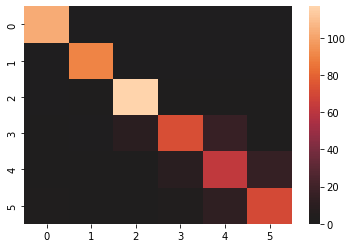

In [22]:
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)

# drawing confusion matrix
sns.heatmap(CM, center = True)
plt.show()

In [23]:
ClassificationReport = classification_report(y_test,y_pred)
print(ClassificationReport)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       103
           1       0.96      1.00      0.98        90
           2       0.89      0.95      0.92       123
           3       0.84      0.71      0.77       101
           4       0.67      0.68      0.68        91
           5       0.80      0.76      0.78        92

    accuracy                           0.86       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.86      0.85       600



In [24]:
def predict(input_text):
    cleaned_input_text = remove_stop_words(clean_text(input_text))
    input_text_vector = tfidfconverter.transform([cleaned_input_text])
    predicted_rating = LogisticRegressionModel.predict(input_text_vector)
    if predicted_rating==1:
        print("Prediction: very bad")
    elif predicted_rating==2:
        print("Prediction:  bad")
    elif predicted_rating==3:
        print("Prediction:  neutral")
    elif predicted_rating==4:
        print("Prediction:  good")
    elif predicted_rating==5:
        print("Prediction:  very good")
        
    

In [26]:
input_text = "Multipliers is a disappointingly overhyped book that fails to deliver on its promise of unleashing the full potential of teams and individuals. The author's attempt to champion leaders who supposedly amplify the intelligence and capabilities of their teams falls flat. In reality, the book is filled with vague anecdotes and buzzwords, lacking concrete strategies or actionable advice. It reads more like a collection of feel-good stories than a practical guide for effective leadership. If you're looking for substantive insights into leadership and team dynamics, look elsewhere.Multipliers  is all talk and no substance, leaving readers with a sense of unfulfilled promises."
predict(input_text)



Prediction:  bad


In [38]:
# Save the sentiment analysis model (LogisticRegressionModel)
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(LogisticRegressionModel, model_file)

# Save the TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidfconverter, vectorizer_file)

# Save your stopwords and lemmatizer
with open('stopwords.pkl', 'wb') as stopwords_file:
    pickle.dump(stop_words, stopwords_file)


In [41]:
with open('clean_words_function.pkl', 'wb') as clean_words_file:
    pickle.dump(clean_text, clean_words_file)